In [1]:
import pathlib

import pandas as pd
from IPython.display import Markdown, display

try:
    cfg = get_ipython().config
    in_notebook = True
except NameError:
    in_notebook = False

    # Get the current working directory
cwd = pathlib.Path.cwd()

if (cwd / ".git").is_dir():
    root_dir = cwd

else:
    root_dir = None
    for parent in cwd.parents:
        if (parent / ".git").is_dir():
            root_dir = parent
            break

# Check if a Git root directory was found
if root_dir is None:
    raise FileNotFoundError("No Git root directory found.")

In [2]:
sc_profiles_path = pathlib.Path(
    root_dir, "data/all_patient_profiles/sc_profiles.parquet"
).resolve(strict=True)
organoid_profiles_path = pathlib.Path(
    root_dir, "data/all_patient_profiles/organoid_profiles.parquet"
).resolve(strict=True)

In [3]:
sc_df = pd.read_parquet(sc_profiles_path)
organoid_df = pd.read_parquet(organoid_profiles_path)

In [4]:
# get the unique combinations of patient and treatment
compounds_counts = (
    organoid_df.groupby(["patient", "treatment"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "count"})
    .drop(columns="count")
    .groupby(["patient"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "number_of_compounds"})
)

In [5]:
# get the unique combinations of patient and treatment
treatments_counts = (
    organoid_df.groupby(["patient", "treatment", "dose"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "count"})
    .drop(columns="count")
    .groupby(["patient"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "number_of_treatments"})
)

In [6]:
# get the unique combinations of patient and treatment
well_counts = (
    sc_df.groupby(["patient", "Well"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "count"})
    .drop(columns="count")
    .groupby(["patient"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "number_of_wells"})
)

In [7]:
well_fov_counts = (
    sc_df.groupby(["patient", "treatment", "Well", "image_set"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "count"})
    .drop(columns="count")
    .groupby(["patient"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "number_of_well_fovs"})
)

In [8]:
organoid_counts = (
    sc_df.groupby(["patient", "treatment", "Well", "image_set", "parent_organoid"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "count"})
    .drop(columns="count")
    .loc[sc_df["parent_organoid"] != -1]
    .groupby(["patient"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "number_of_organoids"})
)

In [9]:
sc_df.groupby(
    [
        "patient",
        "treatment",
        "Well",
        "image_set",
    ]
).size().to_frame().reset_index().rename(columns={0: "count"})
# sum the count at the patient level
sc_df.groupby(
    ["patient", "treatment", "Well", "image_set"]
).size().to_frame().reset_index().rename(columns={0: "count"}).groupby(
    ["patient"]
).sum()

single_cell_counts = (
    sc_df.groupby(["patient", "treatment", "Well", "image_set"])
    .size()
    .to_frame()
    .reset_index()
    .rename(columns={0: "number_of_single_cells"})
    .groupby(["patient"])
    .sum()
    .drop(columns=["treatment", "Well", "image_set"])
    .reset_index()
)

In [10]:
table1 = pd.merge(
    pd.merge(
        pd.merge(
            pd.merge(
                pd.merge(compounds_counts, treatments_counts, on="patient"),
                well_counts,
                on="patient",
            ),
            well_fov_counts,
            on="patient",
        ),
        organoid_counts,
        on="patient",
    ),
    single_cell_counts,
    on="patient",
)

In [11]:
table1["theoretical_number_of_compounds"] = pd.Series([17, 17, 17, 17, 17, 22, 17, 17])
table1["theoretical_number_of_treatments"] = pd.Series([21, 21, 21, 21, 21, 26, 21, 21])
table1["theoretical_number_of_well_fovs"] = pd.Series(
    [104, 125, 162, 350, 208, 420, 199, 350]
)
table1["Tumor type"] = pd.Series(
    [
        "Neurofirbroma (subcutaneous)",
        "Neurofibroma, diffuse and plexiform",
        "Neurofibroma, plexiform, non-contiguous cutaneous",
        "Neurofibroma, plexiform, non-contiguous cutaneous",
        "Myopericytoma",
        "Schwannoma, with degeneration",
        "MPNST in association with plexiform neurofibroma",
        "Sarcoma, treated",
    ]
)
tumor_type = table1.pop("Tumor type")
table1.insert(1, "Tumor type", tumor_type)
table1.rename(
    columns={
        "number_of_compounds": "Compound\nCount",
        "number_of_treatments": "Treatment\nCount",
        "number_of_wells": "Well\nCount",
        "number_of_well_fovs": "Well FOV\nCount",
        "number_of_organoids": "Organoid\nCount",
        "number_of_single_cells": "Single Cell\nCount",
        "theoretical_number_of_compounds": "Theoretical\nCompound Count",
        "theoretical_number_of_treatments": "Theoretical\nTreatment Count",
        "theoretical_number_of_well_fovs": "Theoretical\nWell FOV Count",
    },
    inplace=True,
)

In [12]:
# convert the table to a markdown table
table1_md = table1.to_markdown(index=False, tablefmt="pipe")

In [13]:
# Display the table nicely formatted

# Display as formatted markdown
print("Rendered Table:")
display(Markdown(table1_md))

Rendered Table:


| patient   | Tumor type                                        |   Compound |   Treatment |    Well |   Well FOV |   Organoid |   Single Cell |      Theoretical |       Theoretical |      Theoretical |
|           |                                                   |      Count |       Count |   Count |      Count |      Count |         Count |   Compound Count |   Treatment Count |   Well FOV Count |
|:----------|:--------------------------------------------------|-----------:|------------:|--------:|-----------:|-----------:|--------------:|-----------------:|------------------:|-----------------:|
| NF0014    | Neurofirbroma (subcutaneous)                      |         17 |          21 |      49 |         98 |        121 |          1401 |               17 |                21 |              104 |
| NF0016    | Neurofibroma, diffuse and plexiform               |         16 |          20 |      43 |         77 |         85 |           376 |               17 |                21 |              125 |
| NF0018    | Neurofibroma, plexiform, non-contiguous cutaneous |         17 |          21 |      44 |        106 |        116 |           624 |               17 |                21 |              162 |
| NF0021    | Neurofibroma, plexiform, non-contiguous cutaneous |         17 |          21 |      50 |        307 |        350 |          2716 |               17 |                21 |              350 |
| NF0030    | Myopericytoma                                     |         17 |          21 |      49 |        177 |        196 |          1328 |               17 |                21 |              208 |
| NF0040    | Schwannoma, with degeneration                     |         22 |          26 |      60 |        337 |        382 |          2858 |               22 |                26 |              420 |
| SARCO219  | MPNST in association with plexiform neurofibroma  |         17 |          21 |      50 |        132 |        110 |           426 |               17 |                21 |              199 |
| SARCO361  | Sarcoma, treated                                  |         17 |          21 |      50 |        270 |        256 |          1503 |               17 |                21 |              350 |

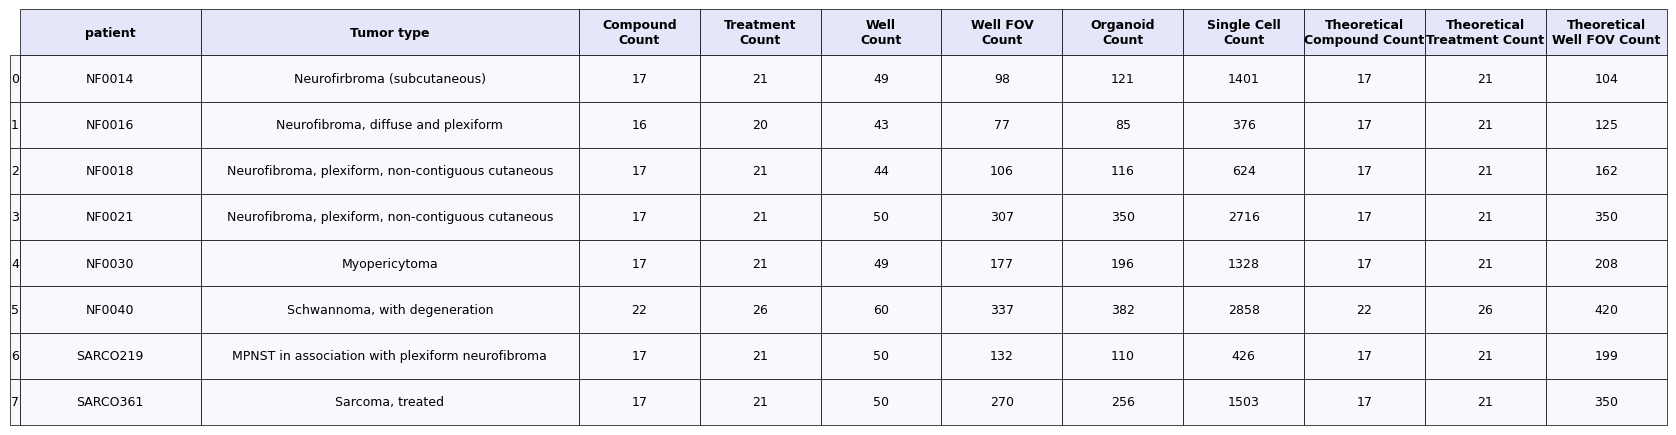

Table saved to: /home/lippincm/Documents/GFF_3D_organoid_profiling_pipeline/figures/table1/table1.svg


In [ ]:
import matplotlib as mpl

# save as table as svg
from matplotlib import pyplot as plt
from pandas.plotting import table

# Set up figure
fig, ax = plt.subplots(figsize=(15, 4))  # Increased width for better text wrapping
ax.axis("off")  # Hide the axes

# Create the table with adjusted column widths for text wrapping
tbl = table(
    ax,
    table1,
    loc="center",
    cellLoc="center",
    colWidths=[0.12, 0.25, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08, 0.08],
)

# Configure table appearance
tbl.auto_set_font_size(False)
tbl.set_fontsize(9)
tbl.scale(1.3, 2.0)  # Increased height scale for text wrapping

# Enable text wrapping for all cells
for (i, j), cell in tbl.get_celld().items():
    cell.set_text_props(wrap=True)
    cell.set_height(0.15)  # Increase cell height for wrapped text

    # Style header row
    if i == 0:
        cell.set_facecolor("#E6E6FA")  # Light purple for header
        cell.set_text_props(weight="bold", wrap=True)
    else:
        cell.set_facecolor("#F8F8FF")  # Very light gray for data rows

    # Add padding and alignment
    cell.set_edgecolor("black")
    cell.set_linewidth(0.5)

# Save with proper path
output_path = pathlib.Path(root_dir, "figures/table1/table1.svg")
output_path.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(output_path, format="svg", bbox_inches="tight", dpi=300)
plt.show()

print(f"Table saved to: {output_path}")